In [67]:
from IPython.display import clear_output

In [68]:
# %pip install torch torchvision torchsummary
# %pip install matplotlib
# %pip install pillow

# clear_output()

# Contents

In this notebook, you will build a custom Pytorch Dataset, add data augmentation to our data and use a Dataloader to process our dataset for training loop.

### The plan

We will save Cifar-10's images in a directory and put the paths and labels into a pandas dataframe.

Then we will use that dataframe as the source of our dataset. This will represent the example of how we can build a custom dataset class, which will work with our custom CSV files

In [69]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import transforms
from torchvision.datasets import CIFAR10
import pandas as pd

from tqdm import tqdm

from time import sleep

%matplotlib inline

## Let's download Cifar10 images

In [70]:
# We're only using this to download dataset. we will manually create a dataset from downloaded files
data = CIFAR10(root='./datasets', train=False, download=True)

Files already downloaded and verified


### Creating the Dataframe

We'll save some of the dataset images in a directory and make a pandas dataframe of the paths which can then be used by our custom Dataset

In [71]:
num_images = 500
img_dir = 'images/'

if not os.path.isdir(img_dir):
  os.makedirs(img_dir)

img_paths = []
img_labels = []

for i in range(num_images):

  img, label = data[i]

  img_name = f'image_{i}.png'
  img_path = os.path.join(img_dir, img_name)

  img.save(img_path)

  img_paths.append(img_path)
  img_labels.append(label)

img_df = pd.DataFrame({
    'img_path': img_paths,
    'label': img_labels
})

In [72]:
img_df.head()

,img_path,label
0,images/image_0.png,3
1,images/image_1.png,8
2,images/image_2.png,8
3,images/image_3.png,0
4,images/image_4.png,6


### Instructions

1. Create a custom dataset class(which inherits pytorch's Dataset)

2. Make this class able to take the Dataframe we created as a parameter.

3. Add 2 more parameters of invert_prob and random_crop_prob in the constructor

4. Implement the dataset. When the dataset gets the item at idx i, it needs to return the image who's path is at the i index in the dataframe as well as the label.

5. The invert_prob and random_crop_prob add into the dataset like this: Everytime a sample is accesed from the dataset, use the invert_prob probability to decide whether the image returned should be inverted and the random_crop_prob probability to decide if we need to apply RandomResizedCrop to it. The Resize Crop shouldn't change the size of the images

6. Create an object of the Dataset and Create a DataLoader using the Dataset Object

7. Write an Empty Loop through the Dataloader. This is to ensure the dataloader and the dataset are running properly

In [73]:
from PIL import ImageOps

class CustomImageDataset(Dataset):
    def __init__(self, img_df, invert_prob, random_crop_prob, transform=None):
        self.img_df = img_df
        self.invert_prob = invert_prob
        self.random_crop_prob = random_crop_prob
        self.transform = transform
        self.default_transform = transforms.ToTensor()
        
    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df.iloc[idx]['img_path']
        label = self.img_df.iloc[idx]['label']
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if random.random() < self.invert_prob:
            img = ImageOps.invert(img)
        if random.random() < self.random_crop_prob:
            original_size = img.size
            img = transforms.RandomCrop(size=original_size)(img)
        img = self.default_transform(img)
        
        return img, label

In [74]:
custom_image_dataset = CustomImageDataset(
    img_df=img_df,
    invert_prob=0.5,
    random_crop_prob=0.5,
)

test_loader = DataLoader(
    custom_image_dataset,
    batch_size=2,
    num_workers=0,
    shuffle=True,
)

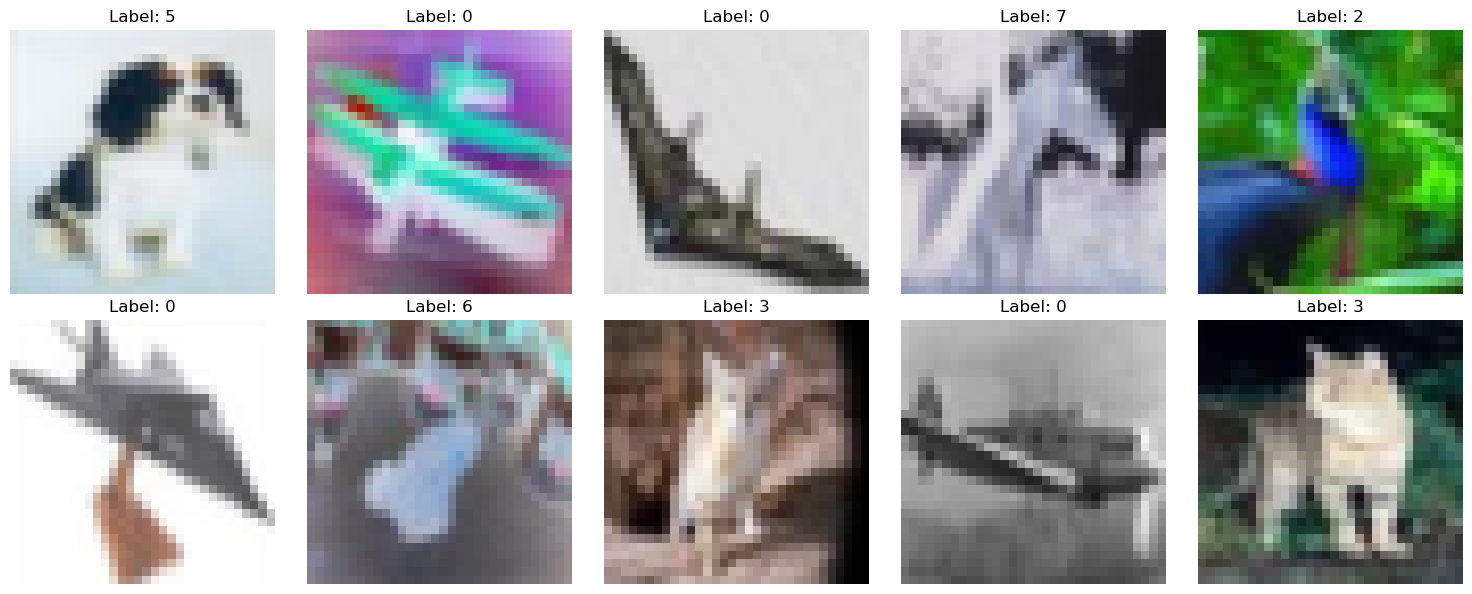

In [75]:
number_of_images = 10
samples = []
count = 0
for images, labels in test_loader:
    for i in range(len(images)):
        if count >= number_of_images:
            break
        samples.append((images[i], labels[i]))
        count += 1
    if count >= number_of_images:
        break

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for ax, (img, label) in zip(axes, samples):
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.set_title(f'Label: {label.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()